# Table of Contents
 <p>

In [20]:
%matplotlib inline
import pickle
import sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from collections import Counter
from collections import defaultdict


def read_pickled_data(path):
    """
    data -- a 10000x3072 numpy array of uint8s. Each row of the array stores a 32x32 colour image. 
        The first 1024 entries contain the red channel values, 
        the next 1024 the green, and the final 1024 the blue. 
        The image is stored in row-major order, 
        so that the first 32 entries of the array are the red channel 
        values of the first row of the image.
        
    labels -- a list of 10000 numbers in the range 0-9. 
        The number at index i indicates the label of the
        ith image in the array data.
    """
    with open(path, 'rb') as fh:
        data = pickle.load(fh, encoding='bytes')
    return data


def rgb_to_grayscale(rgb):
    return np.dot(rgb, [0.299, 0.587, 0.114])


def show_img(img, grayscale=False, ax=None):
    if ax is None:
        fix, ax = plt.subplots()
    if grayscale:
        ax.imshow(img, cmap='gray')
    else:
        ax.imshow(img)


def transform_data_to_gscale(image_list):
    transformed_data = []
    for index, image in enumerate(image_list):
        """
        rgb = rgb[None, ...]
        rgb = rgb.reshape(32,32,3)
        f, (ax1, ax2) = plt.subplots(1, 2)
        show_img(rgb, False, ax1)
        show_img(grayscale, True, ax2)
        if index>10:
        break
        """
        rgb = np.reshape(image, (3, 1024)).T  #*np.array_split(train_image, 3)
        grayscale = rgb_to_grayscale(rgb)
        grayscale_reshaped = np.reshape(rgb_to_grayscale(rgb), (32, 32))
        transformed_data.append(grayscale)
    return transformed_data


def do_PCA(D, N, path_to_data):
    pickled_data = read_pickled_data(path_to_data)
    data = pickled_data[b'data'][:1000, :]
    test_data = data[:N, :]
    train_data = data[N:, ]
    labels = pickled_data[b'labels'][:1000]
    test_labels = labels[:N]
    train_labels = labels[N:]

    train_data_grayscale = np.array(transform_data_to_gscale(train_data))
    test_data_grayscale = np.array(transform_data_to_gscale(test_data))

    pca = PCA(n_components=D, whiten=False, svd_solver='full', tol=0.0)
    fit = pca.fit(np.vstack(train_data_grayscale))
    train_pca = pca.fit_transform(np.vstack(train_data_grayscale))
    test_pca = fit.transform(np.vstack(test_data_grayscale))

    return (train_pca, train_labels, test_pca, test_labels)


def euclidean_dist(x, y):
    diff = np.array(x) - np.array(y)
    return np.sqrt(np.dot(diff, diff.T))


def do_KNN_noweighing(K, test_data, train_data, train_labels):
    test_labels = []
    for index, test_datum in enumerate(test_data):

        distances = []
        for train_datum in train_data:
            distances.append(euclidean_dist(test_datum, train_datum))
        sorted_indexes = np.argsort(distances)[:K]
        nearest_labels = Counter(np.array(train_labels)[sorted_indexes])
        label = nearest_labels.most_common()[0][0]
        test_labels.append(label)
    return test_labels

def do_KNN(K, test_data, train_data, train_labels):
    test_labels = []
    for index, test_datum in enumerate(test_data):

        distances = []
        for train_datum in train_data:
            distances.append(euclidean_dist(test_datum, train_datum))
            
        sorted_indexes = np.argsort(distances)[:K]
        sorted_distances = np.array(distances)[sorted_indexes]
        sorted_labels = np.array(train_labels)[sorted_indexes]
        labels_and_distances = zip(sorted_labels, 1/np.array(sorted_distances))
        labels_and_distances_listed = {}
        for x, y in labels_and_distances:
            labels_and_distances_listed.setdefault(x, []).append(y)
        labels_and_distances_listed_mean = {}
        for key, value in labels_and_distances_listed.items():
            labels_and_distances_listed_mean[key] = np.sum(value)        
        label = max(labels_and_distances_listed_mean, key=labels_and_distances_listed_mean.get)
        test_labels.append(label)
    return test_labels

def main(K, D, N, path_to_data):
    train_pca, train_labels, test_pca, test_labels = do_PCA(D, N, path_to_data)
    predicted_labels = do_KNN(K, test_pca, train_pca, train_labels)
    out = ''
    for predicted, ground in zip(predicted_labels, test_labels):
        out += '{} {}\n'.format(predicted, ground)
    with open('2170058637.txt', 'w') as fh:
        fh.write(out)
    return out


In [21]:
print(main(5, 100, 10, 'data/cifar-10-batches-py/data_batch_1'))
#train_pca, train_labels, test_pca, test_labels = do_PCA(100, 10, 'data/cifar-10-batches-py/data_batch_1')
#euclidean([1,2,3], [3,4,5])

3 6
8 9
9 9
6 4
0 1
1 1
2 2
0 7
6 8
0 3



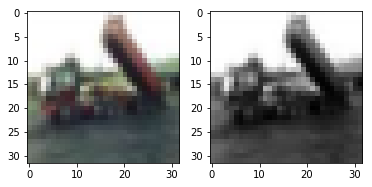

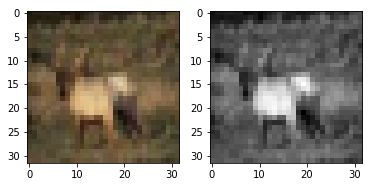

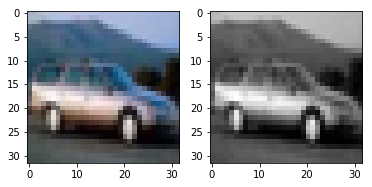

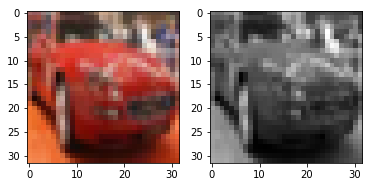

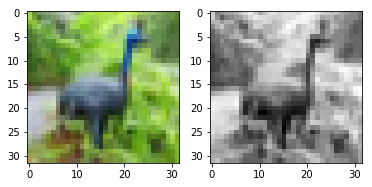

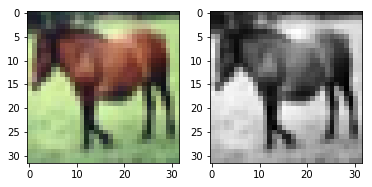

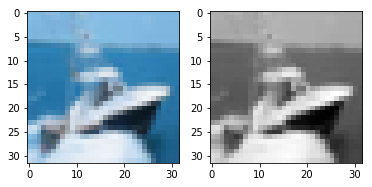

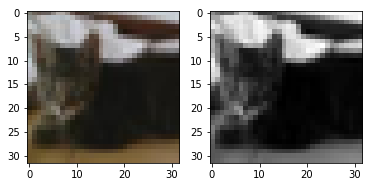

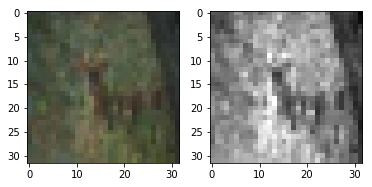

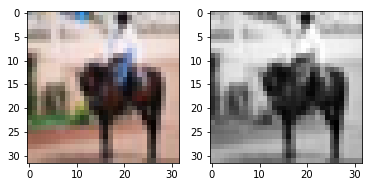

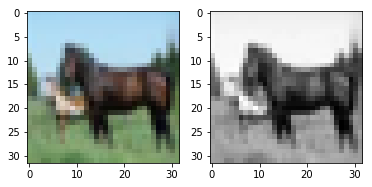

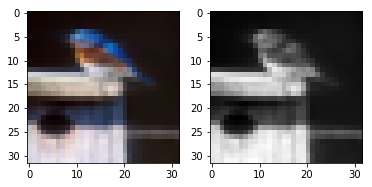

In [50]:
rgb = do_PCA(1, 2, 'data/cifar-10-batches-py/data_batch_1')
